# Toll Visualization
This project displays multiple insights into toll data provided by [Ministerio de Obras Públicas y Comunicaciones (MOPC)](https://datos.gob.do/dataset/traficoestacionespeajerdvial) and [RD VIAL](https://rdvial.gob.do/peajes/) for the years of 2021 and 2022.

Dominican Republic vector shapefile taken from [Cartography Vectors](https://cartographyvectors.com/map/1436-dominican-republic-with-regions).

## Preparing the data

### Cleaning
After taking MOPC data, we explore the data that is provided.

In [84]:
import pandas as pd

toll_traffic_url = 'https://www.mopc.gob.do/media/26614/trafico-de-peaje-rd-vial-2021-2022-noviembre2023.ods'

df = pd.read_excel(toll_traffic_url, engine='odf')

print(df.dtypes)
df.head()

Estaciones           object
Categoria             int64
Tarifa                int64
Total de Trafico      int64
Mes                  object
Año                   int64
dtype: object


,Estaciones,Categoria,Tarifa,Total de Trafico,Mes,Año
0,Americas,1,60,520969,Enero,2021
1,Americas,2,120,39235,Enero,2021
2,Americas,3,180,8825,Enero,2021
3,Americas,4,240,17181,Enero,2021
4,Americas,5,300,347,Enero,2021


Despite the table seems to be alright, I noticed some errors:
- Some columns have spaces in their titles
- Some entries in the month (Mes) column has spaces, creating different unique values for the same month.
- A shown before, string columns were inferred as object columns.

In [85]:
print('Columns with spaces: ', df.columns[df.columns.str.contains(' ')])
print('Unique Months (should be 12): ', len(df['Mes '].unique()))

Columns with spaces:  Index(['Total de Trafico ', 'Mes ', 'Año '], dtype='object')
Unique Months (should be 12):  23


In order to fix these problems:

In [86]:
stripped_columns = {column: column.strip() for column in df.columns}
df.rename(columns=stripped_columns, inplace=True)

df['Estaciones'] = df['Estaciones'].astype('string')
df['Mes'] = df['Mes'].apply(lambda month: month.strip()).astype('string')

df = df.map(lambda x: x.strip() if isinstance(x, str) else x)  # strip all string values in the dataframe

df.head()

,Estaciones,Categoria,Tarifa,Total de Trafico,Mes,Año
0,Americas,1,60,520969,Enero,2021
1,Americas,2,120,39235,Enero,2021
2,Americas,3,180,8825,Enero,2021
3,Americas,4,240,17181,Enero,2021
4,Americas,5,300,347,Enero,2021


When working with time series, it is best to use the datetime column format instead of separate month-year. In order to do this:
1. Change the months to their number counterpart.
2. Create the datetime column based on the month and year column.
3. Considering the data is accounted for until the end of each month, the day should be assigned accordingly.

In [87]:
month_numbers = {month: index+1 for index, month in enumerate(df['Mes'].unique())}
df['Mes'] = df['Mes'].apply(lambda month: month_numbers[month])


def get_last_day_of_month(year, month):
    return pd.to_datetime(f'{year}-{month}-01') + pd.offsets.MonthEnd(1)


df['Fecha'] = df.apply(lambda row: get_last_day_of_month(row['Año'], row['Mes']), axis=1)
df.drop(columns=['Año', 'Mes'], inplace=True)

df.head()

,Estaciones,Categoria,Tarifa,Total de Trafico,Fecha
0,Americas,1,60,520969,2021-01-31
1,Americas,2,120,39235,2021-01-31
2,Americas,3,180,8825,2021-01-31
3,Americas,4,240,17181,2021-01-31
4,Americas,5,300,347,2021-01-31


### Merging
Now that the data from the main toll data is cleaned, we can merge the location data from RDVial to complete the dataset.

Using the name of the station as the merging column, we can add the latitude and longitude to the corresponding station of each entry.

In [88]:
coors_path = './data/locations.csv'
locations_df = pd.read_csv(coors_path)

df = df.merge(locations_df, left_on='Estaciones', right_on='title', how='left')
df.drop(columns=['title'], inplace=True)

df.head()

,Estaciones,Categoria,Tarifa,Total de Trafico,Fecha,lat,lng
0,Americas,1,60,520969,2021-01-31,18.4531,-69.69142
1,Americas,2,120,39235,2021-01-31,18.4531,-69.69142
2,Americas,3,180,8825,2021-01-31,18.4531,-69.69142
3,Americas,4,240,17181,2021-01-31,18.4531,-69.69142
4,Americas,5,300,347,2021-01-31,18.4531,-69.69142


For easier column access, the names of the columns were changed to english lowercase words.

In [89]:
df.rename(columns={
    'Estaciones': 'station',
    'Categoria': 'category',
    'Tarifa': 'rate',
    'Total de Trafico': 'traffic',
    'Fecha': 'date',
}, inplace=True)

df.head()

,station,category,rate,traffic,date,lat,lng
0,Americas,1,60,520969,2021-01-31,18.4531,-69.69142
1,Americas,2,120,39235,2021-01-31,18.4531,-69.69142
2,Americas,3,180,8825,2021-01-31,18.4531,-69.69142
3,Americas,4,240,17181,2021-01-31,18.4531,-69.69142
4,Americas,5,300,347,2021-01-31,18.4531,-69.69142


Finally, we can move the Pandas DataFrame to a GeoPandas DataFrame using the _lng_ and _lat_ columns for the geometry column.

In [90]:
import geopandas as gpd

geodf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lng'], df['lat']))
geodf.drop(columns=['lat', 'lng'], inplace=True)
geodf.head()

,station,category,rate,traffic,date,geometry
0,Americas,1,60,520969,2021-01-31,POINT (-69.69142 18.45310)
1,Americas,2,120,39235,2021-01-31,POINT (-69.69142 18.45310)
2,Americas,3,180,8825,2021-01-31,POINT (-69.69142 18.45310)
3,Americas,4,240,17181,2021-01-31,POINT (-69.69142 18.45310)
4,Americas,5,300,347,2021-01-31,POINT (-69.69142 18.45310)


## Plotting
The dataset is finally complete and we can make the different visualizations!

In [91]:
%matplotlib inline

<Axes: title={'center': 'República Dominicana'}, xlabel='X', ylabel='Y'>

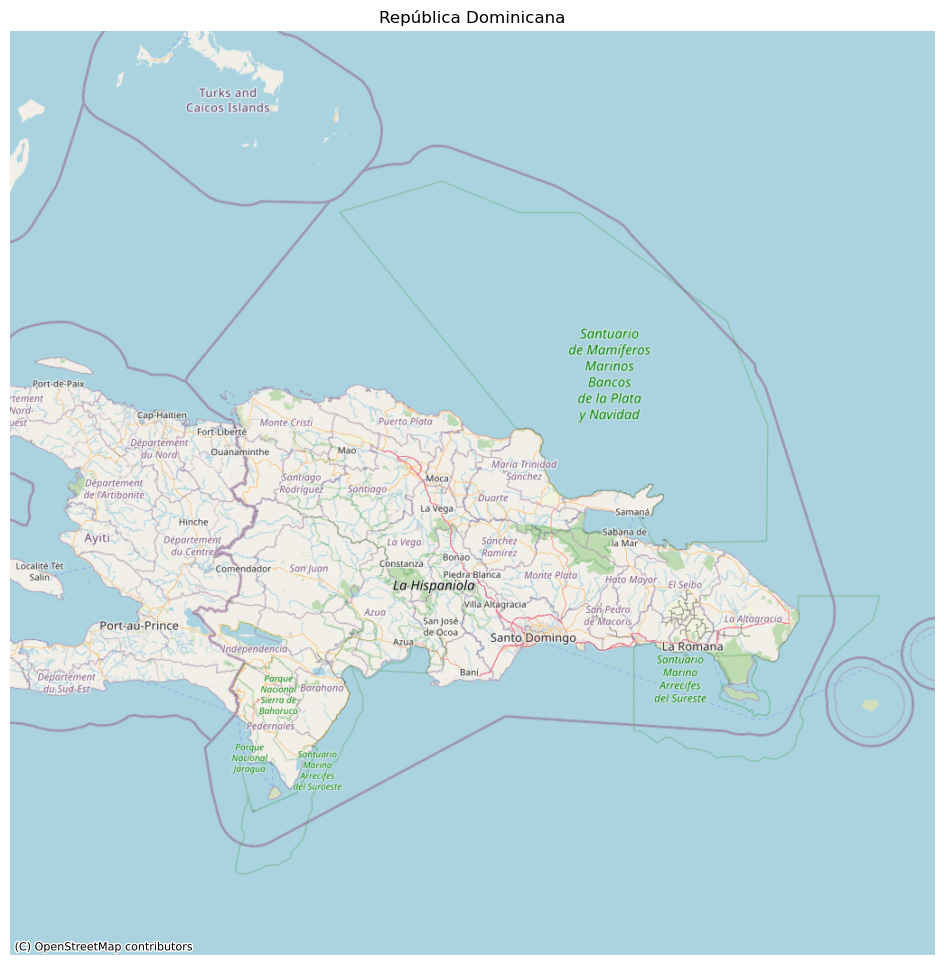

In [117]:
import matplotlib.pyplot as plt
import os
import contextily as ctx

street_map = ctx.providers.OpenStreetMap.Mapnik
dominincan_map = ctx.Place('Dominican Republic', source=street_map, zoom=8)

dominincan_map.plot()

### Bubble Map by Toll Revenue

In [134]:
startDate = '2021-01-01'
endDate = '2022-12-31'

revenue_df = geodf[(startDate <= geodf['date']) & (geodf['date'] <= endDate)].copy()
revenue_df['revenue'] = revenue_df['rate'] * revenue_df['traffic']

revenue_df = revenue_df[['station', 'revenue', 'geometry']].groupby('station').agg({
    'revenue': 'sum',
    'geometry': 'first'
}).reset_index().sort_values(by='revenue', ascending=False)
revenue_df = gpd.GeoDataFrame(revenue_df, geometry='geometry')
revenue_df.crs = "EPSG:4326"
print(revenue_df.crs)
revenue_df.head()

EPSG:4326


,station,revenue,geometry
12,Tramo 1,1650511100,POINT (-70.05065 18.46784)
1,Americas,1516031100,POINT (-69.69142 18.45310)
13,Tramo 2,1400643500,POINT (-70.05070 18.47485)
5,Duarte,1112752260,POINT (-70.08545 18.56738)
10,Sanchez,1052836080,POINT (-70.00117 18.42981)


In [161]:
revenue_df['revenue'].describe()

count    1.500000e+01
mean     8.977719e+08
std      4.278453e+08
min      2.531024e+08
25%      6.016156e+08
50%      9.235509e+08
75%      1.082794e+09
max      1.650511e+09
Name: revenue, dtype: float64

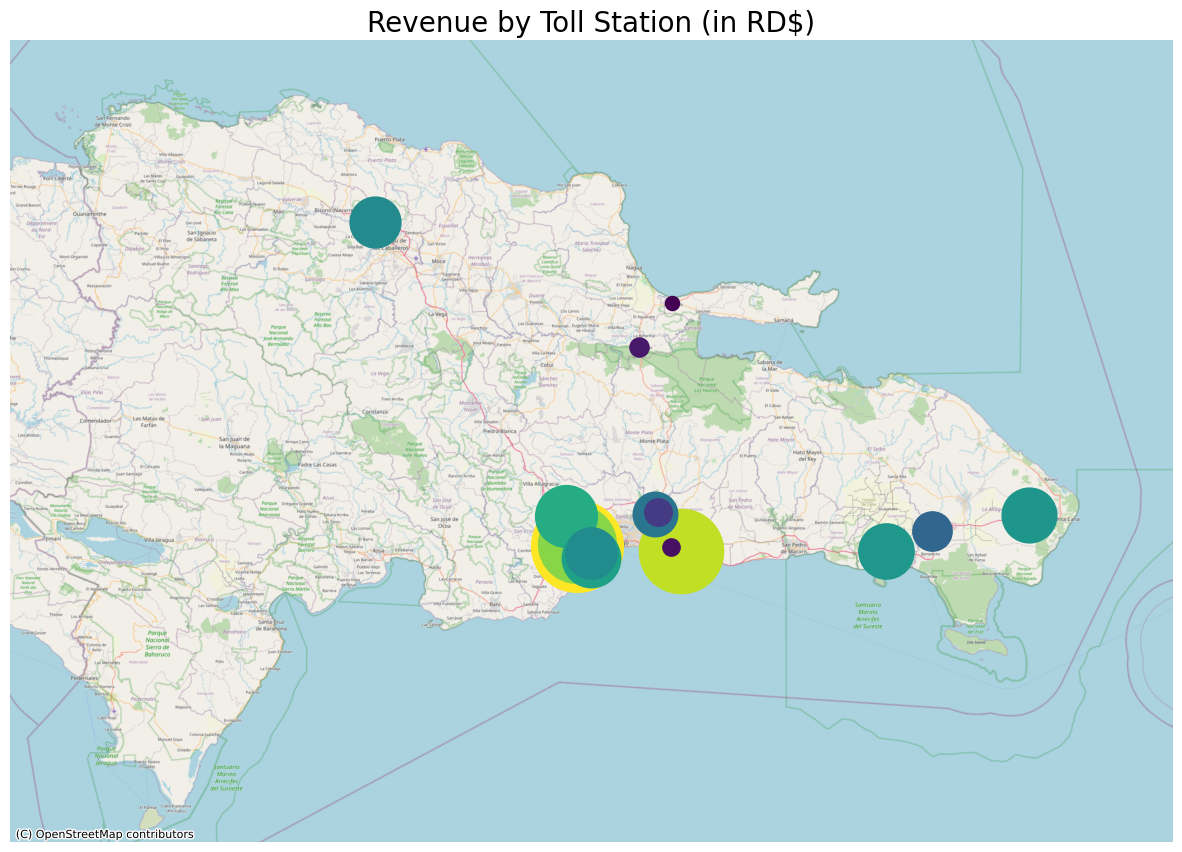

In [185]:
import matplotlib.colors as colors
from matplotlib import colormaps as cmaps

revenue_df = revenue_df.to_crs(epsg=3857)

min_revenue = revenue_df['revenue'].min()
max_revenue = revenue_df['revenue'].max()
norm = colors.Normalize(vmin=min_revenue, vmax=max_revenue)
cmap = cmaps.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(15, 15))

for index, row in revenue_df.iterrows():
    color = cmap(norm(row['revenue']))
    revenue = row['revenue']/(100000000/4)
    ax.plot(row['geometry'].x, row['geometry'].y, marker='o', color=color, markersize=revenue)

minx = -8015003.34
maxx = -7569725.37
miny = 1979106.50
maxy = 2286188.31

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis('off')
ax.set_title('Revenue by Toll Station (in RD$)', fontsize=20)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
plt.show()